In [ ]:
"""
TODO: [mansoor]
    


TODO:
1. create and preprocess/refine antibody structures using seqres2cdr_mapping.py
    - atmseq2cdr and atmseq2paratope mapping

    dict(['complex_code', 'coord_AG', 'label_AG', 'coord_AB', 'label_AB', 
    'edge_AGAB', 'edge_AB', 'edge_AG', 'vertex_AB', 'vertex_AG', 'AbLang_AB', 'ESM1b_AG'])

    1.1 construct 62-dimensional vectors for AB and AG (vertex_AG and vertex_AB)
        - A one-hot encoding representing residue types, with a dimension of 20.
        - A PSSM obtained through PSI-BLAST computation, with a dimension of 20.
        - The absolute and relative SASA computed by STRIDE, with a dimension of 2.
        - A local amino acid profile reveals the frequency of each amino acid type within an 8A ̊ radius of the residue, with a dimension of 20.
    1.2 create label_AG and label_AG of size ATMSEQ (seqres2atmseq masking)
    1.3 generate AG sequence embeddings using ESM2-1b (1280) and AB (768)
        - mask the SEQRES after embedding generation to downstream surf or cdr mask
        - how to encode AB sequence??? not AntiBERTy surely (512)
            - use AbLang model for residue embedding of size 768 per residue
            - it's a RoBERTa inspired language model
    1.4 construct AB and AG individual and joint edges 
        - how to construct these edges? distance threshold of 10A

2. load cvdata.pkl and testdata.pkl and analyze at the data
3. add comments to the code
4. reproduce the reported results in the paper
5. add evaluation metrics of F1 score, precision, recall, BAcc
6. refactor the hyperparameters tuning code (learning rate, batch size, optimizer)


NOTE: 
working of the script:
- takes in cvdata.pkl
- performs k-fold cross-validation
- generates graph using cvdata for each batch in a fold `CreateGearnetGraph()`
- training, validation, and testing in `main.py`
- compute the evaluation metrics for AB and AG
- during testing, calculates metrics for each test sample and takes the average


NOTE:
- torchdrug can't run on local mac due to some c++ error at the backend 

"""

In [1]:
# add other directories to the path to import modules
import sys, os
sys.path.append( os.path.abspath(os.path.join(os.getcwd(), 'm3epi')))
sys.path.append( os.path.abspath(os.path.join(os.getcwd(), '../../walle')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd())))

In [14]:
import pickle
import _pickle as cPickle
import datetime
from Bio import SeqIO

import numpy as np
import pandas as pd
import torch, re
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import pickle, h5py
import _pickle as cPickle
import datetime
from Bio import SeqIO
from Bio.PDB import PDBParser, Polypeptide, PDBIO
from biopandas.pdb import PandasPdb
# from prody import parsePDBHeader
from typing import Optional
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader as PygDataLoader

import warnings
warnings.filterwarnings('ignore')

from omegaconf import DictConfig, OmegaConf
import hydra
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader as PygDataLoader
from utils import *

from model.model import M3EPI
from torch_geometric.data import Data

In [20]:
proj_dir = os.path.join(os.getcwd(), '../../../')
dataset_dir = os.path.join(proj_dir, "data/")
figures_dir = os.path.join(proj_dir, "figures/")
results_dir = os.path.join(proj_dir, "results/hgraphepi/m3epi/")

asep_data_dir = os.path.join(dataset_dir, "asep/")
asep_structures_dir = os.path.join(asep_data_dir, "structures2/")
asep_graphs_dir = os.path.join(asep_data_dir, "asepv1_interim_graphs/")
asep_sequences_dir = os.path.join(asep_data_dir, "sequences/")
asep_processed_data_path = os.path.join(asep_data_dir, "processed")
asep_test_dir = os.path.join(asep_data_dir, "test/")
asep_trans_baselines_dir = os.path.join(asep_data_dir, "trans_baselines")
orig_baselines_dataset_dir = os.path.join(dataset_dir, "orig_baselines")

asep_ag_structures_dir = os.path.join(asep_data_dir, "antigen/structures")
asep_ag_sequences_dir = os.path.join(asep_data_dir, "antigen/sequences")
asep_ag_atmseq2surf_dir = os.path.join(asep_data_dir, "antigen/atmseq2surf")
asep_ab_ag_sequences_fasta_path = os.path.join(asep_sequences_dir, "asep_ab_ag_seqres_1722.fasta")

asep_ab_structures_dir = os.path.join(asep_data_dir, "antibody/structures/")
asep_ab_sequences_dir = os.path.join(asep_data_dir, "antibody/sequences/")
asep_ab_atmseq2cdr_dir = os.path.join(asep_data_dir, "antibody/atmseq2cdr/")
asep_ab_test_atmseq2cdr_dir = os.path.join(asep_data_dir, "antibody/test/atmseq2cdr/")

asep_dict_pre_cal_path = os.path.join(asep_data_dir, "processed", 'dict_pre_cal.pt')
asep_dict_pre_cal_esm2_esm2_path = os.path.join(asep_processed_data_path, 'dict_pre_cal_esm2_esm2.pt')

# antigen sequences and epitope labels
ag_atmseq2epitope_labels = np.load(os.path.join(asep_ag_sequences_dir, "ag_atmseq2epitope_labels.npy"), allow_pickle=True)
ag_seqres2epitope_labels = np.load(os.path.join(asep_ag_sequences_dir, "ag_seqres2epitope_labels.npy"), allow_pickle=True)
ag_binary_epitope_labels = np.load(os.path.join(asep_ag_sequences_dir, "ag_binary_epitope_labels.npy"), allow_pickle=True)
ag_atmseq2epitope_residues = pd.read_csv(os.path.join(asep_ag_sequences_dir, "atmseq2epitope_residues.csv"))
ag_seqres2epitope_residues = pd.read_csv(os.path.join(asep_ag_sequences_dir, "seqres2epitope_residues.csv"))
# ag_atmseq2epitope_residues and ag_seqres2epitope_residues have same epitope residues

# antibody sequences and paratope labels
ab_cdr2paratope_labels = np.load(os.path.join(asep_ab_sequences_dir, "cdr2paratope_mask.npy"), allow_pickle=True)
ab_seqres2paratope_labels = np.load(os.path.join(asep_ab_sequences_dir, "seqres2paratope_mask.npy"), allow_pickle=True)
# ab_paratope_labels_chainwise = pd.read_csv(os.path.join(asep_ab_sequences_dir, "seqres2atmseq_mask_ab_HL_chain.csv"))
ab_atmseq2paratope_residues = pd.read_csv(os.path.join(asep_ab_sequences_dir, "atmseq2paratope_residues.csv"))
ab_seqres2paratope_residues = pd.DataFrame(np.load(os.path.join(asep_ab_sequences_dir, "seqres2paratope_residues.npy"), allow_pickle=True),
                                           columns=["pdbid", "paratope", "seqres2paratope_mask", "seqres2cdr_mask"])

# M3Epi data
m3epi_asep_transform_dir = os.path.join(asep_data_dir, "m3epi")
m3epi_pkl_path = os.path.join(m3epi_asep_transform_dir, "asep_mipe_transformed_100_examples.pkl")
# m3epi_test_results = pd.read_csv(os.path.join(results_dir, "test_results.csv"))
# mipe_test_results = pd.read_csv(os.path.join(results_dir, "test_results_asep_data.csv"))

m3epi_checkpoints_dir = os.path.join(results_dir, "checkpoints")
m3epi_figures_dir = os.path.join(results_dir, "figures")


In [9]:
# @hydra.main(config_path="conf", config_name="config")
# def main(cfg: DictConfig):
print("test")
# load your checkpoint (must have saved the config too!)
ckpt = torch.load(os.path.join(m3epi_checkpoints_dir, "model-02-7.17.pt"), map_location="cpu")

print(ckpt)

# rehydrate the saved plain‐dict into a DictConfig
model_cfg = OmegaConf.create(ckpt["config"])
model = M3EPI(model_cfg)
model.load_state_dict(ckpt['model_state_dict']) 


test
{'model_state_dict': OrderedDict([('ag_encoder.layers.0.conv.eps', tensor([0.])), ('ag_encoder.layers.0.conv.nn.0.weight', tensor([[ 0.1365, -0.0508, -0.0682,  ...,  0.1537, -0.0748, -0.0876],
        [-0.0869,  0.1603, -0.0855,  ...,  0.1475,  0.0298, -0.0411],
        [ 0.0846,  0.1026,  0.0364,  ..., -0.1350,  0.0059, -0.1086],
        ...,
        [ 0.0198, -0.0073,  0.0119,  ..., -0.1321,  0.0208,  0.0607],
        [ 0.0646,  0.1034,  0.0523,  ...,  0.0204,  0.1297, -0.0018],
        [-0.0460, -0.0517, -0.1036,  ..., -0.0575, -0.1543,  0.0641]])), ('ag_encoder.layers.0.conv.nn.0.bias', tensor([-0.1388, -0.0454, -0.0223,  0.1298,  0.1364,  0.1583,  0.1420,  0.0060,
        -0.1193, -0.1491,  0.0492, -0.1077, -0.1243, -0.1423, -0.0214,  0.0768,
        -0.1571, -0.1196,  0.1313,  0.1289, -0.1208,  0.0756,  0.0010, -0.0440,
        -0.1430, -0.0759,  0.0188, -0.0471, -0.0330, -0.1420, -0.0066,  0.0966])), ('ag_encoder.layers.0.conv.nn.2.weight', tensor([[-0.1627, -0.0291,  0.102

<All keys matched successfully>

In [ ]:
class PairData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == "edge_index_b":
            return self.x_b.size(0)
        if key == "edge_index_g":
            return self.x_g.size(0)
        if key == "edge_index_ag_ab":
            # ensure the right increment for batching
            return torch.tensor([[self.x_b.size(0)], [self.x_g.size(0)]])
        return super().__inc__(key, value, *args, **kwargs)


def create_dataloader(dataset, cfg):
    data_list = []
    for item in dataset:
        pair = PairData(
            x_b=torch.tensor(item["vertex_AB"], dtype=torch.float),
            edge_index_b=torch.tensor(item["edge_AB"], dtype=torch.long),
            y_b=torch.tensor(item["label_AB"], dtype=torch.float),
            x_g=torch.tensor(item["vertex_AG"], dtype=torch.float),
            edge_index_g=torch.tensor(item["edge_AG"], dtype=torch.long),
            y_g=torch.tensor(item["label_AG"], dtype=torch.float),
            edge_index_ag_ab=torch.tensor(item["edge_AGAB"], dtype=torch.long),
        )
        data_list.append(pair)
    return PygDataLoader(
        data_list,
        batch_size=cfg.hparams.train.batch_size,
        shuffle=True,
        follow_batch=["x_g", "x_b"]
    )

In [23]:
data = load_data(os.path.join(m3epi_asep_transform_dir, "asep_mipe_transformed_100_examples.pkl"))

# one big batch so we get every node's embedding
loader = create_dataloader(data[:10])
ag_emb, ag_lbl, ab_emb, ab_lbl = extract_embeddings(model, loader, "cpu")


→ saved /Users/mansoor/Documents/GSU/Projects/Antibody-Design/epitope-prediction/hgraphepi/m3epi/code/../../../results/hgraphepi/m3epi/figures/tsne_antigen.png


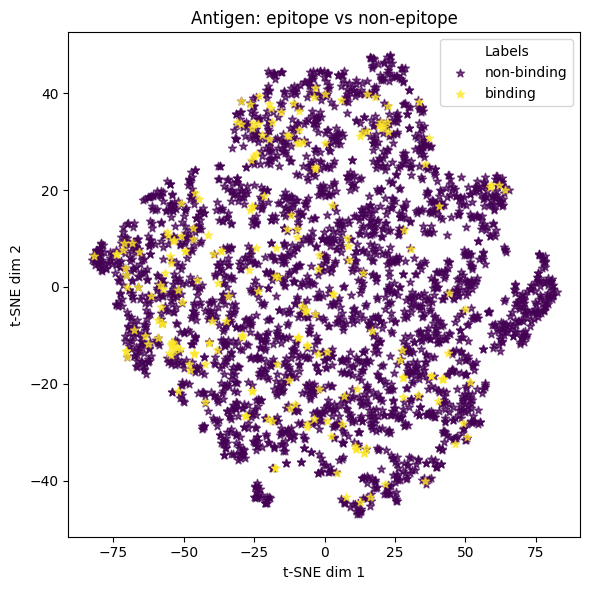

→ saved /Users/mansoor/Documents/GSU/Projects/Antibody-Design/epitope-prediction/hgraphepi/m3epi/code/../../../results/hgraphepi/m3epi/figures/tsne_antibody.png


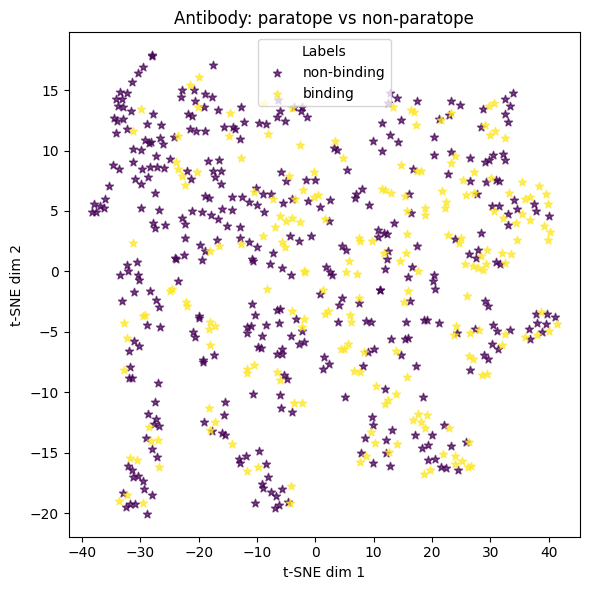

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import numpy as np

def plot_tsne(emb, labels, title, out_path, label_mapping):
    tsne = TSNE(n_components=2, random_state=42)
    emb2d = tsne.fit_transform(emb)

    # Create a colormap
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(6, 6))
    for i, label in enumerate(unique_labels):
        idx = labels == label
        plt.scatter(emb2d[idx, 0], emb2d[idx, 1], c=[colors(i)], alpha=0.7, marker="*", label=label_mapping[label])

    plt.title(title)
    plt.xlabel('t-SNE dim 1')
    plt.ylabel('t-SNE dim 2')
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    print(f"→ saved {out_path}")
    # plt.show()
    plt.close()

# Example usage
# Assuming ag_emb and ag_lbl are defined and m3epi_figures_dir is a valid directory path
label_mapping = {0: "non-binding", 1: "binding"}

plot_tsne(
    ag_emb, ag_lbl,
    "Antigen: epitope vs non‑epitope",
    os.path.join(m3epi_figures_dir, "tsne_antigen.png"),
    label_mapping
)
# plot antibodies
plot_tsne(
    ab_emb, ab_lbl,
    "Antibody: paratope vs non‑paratope",
    os.path.join(m3epi_figures_dir, "tsne_antibody.png"),
    label_mapping
)


In [10]:

def extract_embeddings(model, loader, device):
    model.eval()
    ag_embs, ab_embs = [], []
    ag_labels, ab_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            ag_embs.append(out['ag_embed'].cpu())
            ab_embs.append(out['ab_embed'].cpu())
            ag_labels.append(batch.y_g.cpu())
            ab_labels.append(batch.y_b.cpu())
    return (
        torch.cat(ag_embs).numpy(),
        torch.cat(ag_labels).numpy(),
        torch.cat(ab_embs).numpy(),
        torch.cat(ab_labels).numpy()
    )


In [5]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

class EpitopeDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data_list = [
            Data(
                x=torch.tensor(item["vertex_AG"], dtype=torch.float),
                edge_index=torch.tensor(item["edge_AG"], dtype=torch.long),
                y=torch.tensor(item["label_AG"], dtype=torch.float),
                pos=torch.tensor(item["coord_AG"], dtype=torch.float)
            )
            for item in data
        ]

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

m3epi_test_data = torch.load(m3epi_pkl_path)

# Initialize the dataset
dataset = EpitopeDataset(m3epi_test_data)

# Create data loaders
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset, batch_size=10, shuffle=False)

# Check the dimensions of the embeddings in the batches
for batch in train_loader:
    print(f"Batch x shape: {batch.x.shape}")
    print(f"Batch edge_index shape: {batch.edge_index.shape}")
    print(f"Batch y shape: {batch.y.shape}")
    print(f"Batch pos shape: {batch.pos.shape}")
    print(f"Number of graphs in batch: {batch.num_graphs}")
    print(f"Batch indices: {batch.batch}")
    # break

Batch x shape: torch.Size([3320, 40])
Batch edge_index shape: torch.Size([2, 26328])
Batch y shape: torch.Size([3320])
Batch pos shape: torch.Size([3320, 3])
Number of graphs in batch: 10
Batch indices: tensor([0, 0, 0,  ..., 9, 9, 9])
Batch x shape: torch.Size([3710, 40])
Batch edge_index shape: torch.Size([2, 27970])
Batch y shape: torch.Size([3710])
Batch pos shape: torch.Size([3710, 3])
Number of graphs in batch: 10
Batch indices: tensor([0, 0, 0,  ..., 9, 9, 9])
Batch x shape: torch.Size([2128, 40])
Batch edge_index shape: torch.Size([2, 16300])
Batch y shape: torch.Size([2128])
Batch pos shape: torch.Size([2128, 3])
Number of graphs in batch: 10
Batch indices: tensor([0, 0, 0,  ..., 9, 9, 9])
Batch x shape: torch.Size([3482, 40])
Batch edge_index shape: torch.Size([2, 26804])
Batch y shape: torch.Size([3482])
Batch pos shape: torch.Size([3482, 3])
Number of graphs in batch: 10
Batch indices: tensor([0, 0, 0,  ..., 9, 9, 9])
Batch x shape: torch.Size([2427, 40])
Batch edge_index s

In [6]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.data_list = [
            Data(x=torch.randn(5, 3), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long)),
            Data(x=torch.randn(3, 3), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
            Data(x=torch.randn(7, 3), edge_index=torch.tensor([[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]], dtype=torch.long))
        ]

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

dataset = MyDataset()
dataloader = DataLoader(dataset, batch_size=2)

for batch in dataloader:
    print(batch)
    print(batch.num_graphs)
    print(batch.batch)
    print(batch.x)
    print(batch.edge_index)

DataBatch(x=[8, 3], edge_index=[2, 6], batch=[8], ptr=[3])
2
tensor([0, 0, 0, 0, 0, 1, 1, 1])
tensor([[-1.2812,  0.3258,  1.6303],
        [-0.6474,  0.2160, -1.4070],
        [-0.9738, -1.6743, -0.1094],
        [ 0.0379, -1.0517,  0.1595],
        [ 0.6497, -0.5433, -0.3332],
        [-0.6990, -0.0279, -1.0119],
        [ 0.4033, -0.1097, -2.1455],
        [-0.1422, -0.7924,  1.5620]])
tensor([[0, 1, 2, 3, 5, 6],
        [1, 2, 3, 4, 6, 7]])
DataBatch(x=[7, 3], edge_index=[2, 6], batch=[7], ptr=[2])
1
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([[-0.2416,  0.2945,  1.7959],
        [-0.8363, -0.8236, -0.0443],
        [-0.3506, -0.4382,  0.9411],
        [ 1.1027,  0.5196, -0.9928],
        [-0.7652, -1.9806,  0.4351],
        [ 0.8705, -1.2711, -0.0983],
        [ 1.7343,  0.4950, -0.4334]])
tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 6]])


In [29]:
import numpy as np

def edge_list_to_adjacency_matrix(edge_list, num_ag_nodes=None, num_ab_nodes=None, directed=True, weighted=False):
    """
    Convert an edge list to an adjacency matrix.

    Args:
        edge_list (list of tuples): The edge list of the graph. Each tuple can be (i, j) or (i, j, weight).
        num_nodes (int, optional): The number of nodes in the graph. If not provided, it will be inferred from the edge list.
        directed (bool): Whether the graph is directed or undirected.
        weighted (bool): Whether the graph is weighted or unweighted.

    Returns:
        adj_matrix (np.ndarray): The adjacency matrix of the graph.
    """
    if num_ag_nodes is None:
        num_ag_nodes = max(max(i, j) for i, j, *_ in edge_list) + 1

    adj_matrix = np.zeros((num_ag_nodes, num_ab_nodes), dtype=int if not weighted else float)

    for edge in edge_list:
        # print(edge)
        if weighted:
            i, j, weight = edge
            adj_matrix[i][j] = weight
        else:
            i, j = edge
            adj_matrix[i][j] = 1

        if not directed:
            adj_matrix[j][i] = adj_matrix[i][j]

    return adj_matrix

# Example usage
edge_list = [(0, 1), (1, 2), (1, 3), (2, 3)]
edge_list = batch[0].edge_index_bg

adj_matrix = edge_list_to_adjacency_matrix(edge_list.T, num_ag_nodes=62, num_ab_nodes=64, directed=False)
print(adj_matrix.shape)


(62, 64)


In [12]:
edge_list = batch[0].edge_index_bg
edge_list.T.shape

torch.Size([39, 2])

In [71]:
asep_graphs_processed = torch.load(asep_dict_pre_cal_esm2_esm2_path)


# Create the DataLoader
m3epi_data_loader = PygDataLoader(list(asep_graphs_processed.values()), batch_size=100, shuffle=True
)

# Check the dimensions of the embeddings in the batches
for batch in m3epi_data_loader:
    print(f"Batch edge_index shape: {batch.x_b.shape}")
    print(f"Batch x shape: {batch.x_g.shape}")
    break


Batch edge_index shape: torch.Size([6099, 480])
Batch x shape: torch.Size([30692, 480])


In [ ]:

import os
import hydra
from omegaconf import DictConfig
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import wandb
from pathlib import Path
import numpy as np
from sklearn.model_selection import KFold

from model.model import M3EPI
from model.loss import binary_cross_entropy, ntxent_loss
from model.metric import EpitopeMetrics
from model.callbacks import EarlyStopping, ModelCheckpoint
from utils import seed_everything, get_device, load_data, initialize_wandb

class EpitopeDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        item = self.data[idx]
        del self.data[idx]["complex_code"]
        # print(f"Item {idx}: {item}")  
        return {k: torch.tensor(v) for k, v in self.data[idx].items()}

def train_epoch(model, train_loader, optimizer, device, metrics):
    model.train()
    total_loss = 0
    metrics.reset()
    
    for batch in train_loader:
        # Move data to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(batch)
        
        # Calculate losses
        edge_loss = binary_cross_entropy(
            outputs['interaction_probs'], 
            batch['edge_AGAB']
        )
        node_loss = binary_cross_entropy(
            outputs['epitope_pred'], 
            batch['label_AG']
        )
        contrast_loss = ntxent_loss(
            outputs['ag_embed'], 
            outputs['ab_embed']
        )
        
        loss = edge_loss + node_loss + 0.1 * contrast_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        metrics.update(outputs['epitope_pred'], batch['label_AG'])
        
    return total_loss / len(train_loader), metrics.compute()

def validate_epoch(model, val_loader, device, metrics):
    model.eval()
    total_loss = 0
    metrics.reset()
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch)
            
            edge_loss = binary_cross_entropy(
                outputs['interaction_probs'], 
                batch['edge_AGAB']
            )
            node_loss = binary_cross_entropy(
                outputs['epitope_pred'], 
                batch['label_AG']
            )
            
            loss = edge_loss + node_loss
            total_loss += loss.item()
            metrics.update(outputs['epitope_pred'], batch['label_AG'])
            
    return total_loss / len(val_loader), metrics.compute()

@hydra.main(config_path="conf", config_name="config")
def main(cfg: DictConfig):
    # Set random seed
    seed_everything(cfg.seed)
    
    # Setup device
    device = get_device()
    
    # Load data
    data = load_data(cfg.data_dir + "/asep_mipe_transformed_100_examples.pkl")
    
    # Initialize wandb
    if cfg.logging_method == 'wandb':
        initialize_wandb(cfg)
    
    # Setup k-fold cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=cfg.seed)
    
    # Track best metrics across folds
    best_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
        print(f"\nTraining Fold {fold+1}")
        
        # Create data loaders
        train_loader = DataLoader(
            EpitopeDataset([data[i] for i in train_idx]),
            batch_size=cfg.hparams.train.batch_size,
            shuffle=True
        )
        
        val_loader = DataLoader(
            EpitopeDataset([data[i] for i in val_idx]),
            batch_size=cfg.hparams.val.batch_size
        )
        
        # Initialize model
        model = M3EPI(cfg).to(device)
        
        # Setup optimizer
        optimizer = Adam(
            model.parameters(),
            lr=cfg.hparams.train.learning_rate,
            weight_decay=cfg.hparams.train.weight_decay
        )
        
        # Setup callbacks
        early_stopping = EarlyStopping(**cfg.callbacks.early_stopping)
        model_checkpoint = ModelCheckpoint(**cfg.callbacks.model_checkpoint)
        metrics = EpitopeMetrics()
        
        # Training loop
        for epoch in range(cfg.hparams.train.num_epochs):
            train_loss, train_metrics = train_epoch(
                model, train_loader, optimizer, device, metrics
            )
            val_loss, val_metrics = validate_epoch(
                model, val_loader, device, metrics
            )
            
            # Log metrics
            if cfg.logging_method == 'wandb':
                wandb.log({
                    f'fold_{fold+1}/train_loss': train_loss,
                    f'fold_{fold+1}/val_loss': val_loss,
                    **{f'fold_{fold+1}/train_{k}': v for k, v in train_metrics.items()},
                    **{f'fold_{fold+1}/val_{k}': v for k, v in val_metrics.items()},
                    'epoch': epoch
                })
            
            # Save checkpoint
            model_checkpoint(model, val_loss, epoch)
            
            # Early stopping
            if early_stopping(val_loss):
                print(f"Early stopping triggered at epoch {epoch}")
                break
                
        best_metrics.append(val_metrics)
        
    # Print final results
    metrics_avg = {
        k: np.mean([m[k] for m in best_metrics]) 
        for k in best_metrics[0].keys()
    }
    metrics_std = {
        k: np.std([m[k] for m in best_metrics]) 
        for k in best_metrics[0].keys()
    }
    
    print("\nFinal Results:")
    for k in metrics_avg.keys():
        print(f"{k}: {metrics_avg[k]:.4f} ± {metrics_std[k]:.4f}")
        
    if cfg.logging_method == 'wandb':
        wandb.finish()

if __name__ == "__main__":
    main()





In [5]:
AA_MAP = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y"
}

In [13]:
asep_graphs_processed = torch.load(asep_dict_pre_cal_esm2_esm2_path)
asep_graphs_processed

{'3v6o_1P': PairData(x_b=[55, 480], x_g=[171, 480], edge_index_b=[2, 352], edge_index_g=[2, 1240], abdbid='3v6o_1P', edge_index_bg=[2, 43], y_b=[55], y_g=[171]),
 '1s78_0P': PairData(x_b=[57, 480], x_g=[495, 480], edge_index_b=[2, 362], edge_index_g=[2, 3726], abdbid='1s78_0P', edge_index_bg=[2, 44], y_b=[57], y_g=[495]),
 '7mzg_0P': PairData(x_b=[57, 480], x_g=[178, 480], edge_index_b=[2, 342], edge_index_g=[2, 1384], abdbid='7mzg_0P', edge_index_bg=[2, 69], y_b=[57], y_g=[178]),
 '4f9l_1P': PairData(x_b=[60, 480], x_g=[201, 480], edge_index_b=[2, 386], edge_index_g=[2, 1508], abdbid='4f9l_1P', edge_index_bg=[2, 37], y_b=[60], y_g=[201]),
 '6wh9_2P': PairData(x_b=[63, 480], x_g=[400, 480], edge_index_b=[2, 416], edge_index_g=[2, 3246], abdbid='6wh9_2P', edge_index_bg=[2, 55], y_b=[63], y_g=[400]),
 '6d0u_0P': PairData(x_b=[76, 480], x_g=[229, 480], edge_index_b=[2, 518], edge_index_g=[2, 1668], abdbid='6d0u_0P', edge_index_bg=[2, 36], y_b=[76], y_g=[229]),
 '5o14_1P': PairData(x_b=[61

In [141]:
""" 
TODO: 
- load antibody cdr pdb files and reorder as H+L chains
- load antigen surf pdb files
- filter out the 3d coordinates of the CA atom from these pdb files
1.1 construct 62-dimensional vectors for AB and AG (vertex_AG and vertex_AB)
    - A one-hot encoding representing residue types, with a dimension of 20.
    - A PSSM obtained through PSI-BLAST computation, with a dimension of 20.
    - The absolute and relative SASA computed by STRIDE, with a dimension of 2.
    - A local amino acid profile reveals the frequency of each amino acid type 
    within an 8A ̊ radius of the residue, with a dimension of 20.

"""

pdb_id = "3v6o_1P"
ag_pdb_df = PandasPdb().read_pdb(os.path.join(asep_ag_atmseq2surf_dir, f'{pdb_id}_surf.pdb'))
filtered_ag_df = ag_pdb_df.df["ATOM"][ag_pdb_df.df["ATOM"].loc[:,"atom_name"]=="CA"]
ag_pdb_coordinates = filtered_ag_df[["x_coord", "y_coord", "z_coord"]]

# Read antibody PDB for both chains
ab_pdb_df = PandasPdb().read_pdb(os.path.join(asep_ab_atmseq2cdr_dir, f'{pdb_id}_cdr.pdb'))
ab_pdb_df = ab_pdb_df.get_model(1).df["ATOM"]

# Get residue numbers (indices) that are CDR (mask = 1) for both chains
cdr_pdb_df_L = ab_pdb_df[ ab_pdb_df["chain_id"] == 'L']
cdr_pdb_df_H = ab_pdb_df[ ab_pdb_df["chain_id"] == 'H']

# enforce H+L chain order for the filtered ab dataframe to do cdr and paratope masking later on
filtered_ab_df = pd.concat([cdr_pdb_df_H, cdr_pdb_df_L])
filtered_ab_df = filtered_ab_df[filtered_ab_df.loc[:,"atom_name"]=="CA"]
ab_pdb_coordinates = filtered_ab_df[["x_coord", "y_coord", "z_coord"]]
# print(ab_pdb_coordinates) 
print(ag_pdb_coordinates)

      x_coord  y_coord  z_coord
1      27.029   75.369   -1.123
6      30.294   73.723   -2.222
14     33.635   74.968   -0.789
22     36.655   73.567   -2.595
30     39.548   72.590   -0.281
...       ...      ...      ...
1330   67.651   77.572  -10.351
1338   69.170   78.157  -13.786
1345   72.588   76.660  -14.649
1350   74.733   78.328  -17.311
1362   77.258   76.481  -19.505

[171 rows x 3 columns]


In [80]:
seqres2paratope_mask = np.array(ab_seqres2paratope_residues[ab_atmseq2paratope_residues["pdbid"] == "7f3q_0P"]["seqres2paratope_mask"][0])
seqres2paratope_mask

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [86]:
seqres2cdr_mask = np.array(ab_seqres2paratope_residues[ab_atmseq2paratope_residues["pdbid"] == "7f3q_0P"]["seqres2cdr_mask"][0])
seqres2cdr_mask

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [143]:
# create dictionary for faster access
ab_cdr2paratope_labels_dict = {item[0]: (item[1], item[2]) for item in ab_cdr2paratope_labels}
cdr2paratope_mask = ab_cdr2paratope_labels_dict["1a14_0P"]
cdr2paratope_mask

(['26_Y_H',
  '27_T_H',
  '53_N_H',
  '54_G_H',
  '55_D_H',
  '56_T_H',
  '24_A_L',
  '26_Q_L',
  '27_D_L',
  '53_L_L',
  '54_H_L',
  '55_S_L'],
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [144]:
pdb_id = "3v6o_1P"
print(asep_graphs_processed[pdb_id]["edge_index_bg"])
# print(asep_graphs_processed[pdb_id]["edge_index_g"])
# print(asep_graphs_processed[pdb_id]["edge_index_b"])
print(asep_graphs_processed[pdb_id]["edge_index_bg"][0])
print(asep_graphs_processed[pdb_id]["edge_index_bg"][1])
edge_index_bg = torch.tensor([asep_graphs_processed[pdb_id]["edge_index_bg"][1].tolist(),
                                                  asep_graphs_processed[pdb_id]["edge_index_bg"][0].tolist()])
edge_index_bg 


tensor([[ 5,  5,  5,  6,  6, 12, 12, 13, 14, 15, 16, 16, 18, 18, 20, 20, 21, 22,
         22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 39, 39, 39, 42, 48, 49, 49,
         49, 49, 50, 50, 51, 51, 53],
        [29, 62, 64, 29, 64, 43, 45, 45, 45, 45, 45, 46, 26, 44, 29, 31, 29, 27,
         28, 29, 43, 45, 28, 29, 30, 31, 32, 41, 31, 30, 31, 32, 32, 43, 40, 41,
         42, 43, 42, 43, 42, 43, 43]])
tensor([ 5,  5,  5,  6,  6, 12, 12, 13, 14, 15, 16, 16, 18, 18, 20, 20, 21, 22,
        22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 39, 39, 39, 42, 48, 49, 49,
        49, 49, 50, 50, 51, 51, 53])
tensor([29, 62, 64, 29, 64, 43, 45, 45, 45, 45, 45, 46, 26, 44, 29, 31, 29, 27,
        28, 29, 43, 45, 28, 29, 30, 31, 32, 41, 31, 30, 31, 32, 32, 43, 40, 41,
        42, 43, 42, 43, 42, 43, 43])


tensor([[29, 62, 64, 29, 64, 43, 45, 45, 45, 45, 45, 46, 26, 44, 29, 31, 29, 27,
         28, 29, 43, 45, 28, 29, 30, 31, 32, 41, 31, 30, 31, 32, 32, 43, 40, 41,
         42, 43, 42, 43, 42, 43, 43],
        [ 5,  5,  5,  6,  6, 12, 12, 13, 14, 15, 16, 16, 18, 18, 20, 20, 21, 22,
         22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 39, 39, 39, 42, 48, 49, 49,
         49, 49, 50, 50, 51, 51, 53]])

In [206]:
mipe_cvdata_pkl = torch.load(mipe_cvdata_pkl_path, map_location=torch.device('cpu'))
print(mipe_cvdata_pkl[0].keys())


dict_keys(['complex_code', 'coord_AG', 'label_AG', 'coord_AB', 'label_AB', 'edge_AGAB', 'edge_AB', 'edge_AG', 'vertex_AB', 'vertex_AG', 'AbLang_AB', 'ESM1b_AG'])
<class 'list'>


In [287]:
print(asep_mipe_transformed[0]["coord_AG"])
print(asep_mipe_transformed[0]["label_AG"])
print(asep_mipe_transformed[0]["coord_AB"])
print(asep_mipe_transformed[0]["label_AB"])
print(asep_mipe_transformed[0]["edge_AGAB"])
print(asep_mipe_transformed[0]["edge_AB"])
print(asep_mipe_transformed[0]["edge_AG"])
print(asep_mipe_transformed[0]["vertex_AB"])
print(asep_mipe_transformed[0]["vertex_AG"])
print(asep_mipe_transformed[0]["AbLang_AB"])
print(asep_mipe_transformed[0]["ESM1b_AG"])

[[91.598, 92.519, 135.676], [92.634, 94.464, 132.573], [95.273, 97.162, 132.219], [93.761, 100.618, 131.864], [95.44, 103.146, 129.544], [98.462, 104.778, 131.122], [99.686, 104.77, 127.516], [96.943, 107.134, 126.33], [97.921, 109.711, 128.979], [101.733, 109.437, 128.726], [102.23, 108.452, 125.068], [99.418, 110.541, 123.573], [100.468, 112.193, 120.323], [99.265, 115.722, 121.155], [98.945, 117.335, 124.586], [96.606, 120.125, 125.637], [97.556, 123.659, 126.614], [98.077, 124.547, 130.265], [95.024, 126.824, 130.453], [92.938, 123.961, 129.024], [94.616, 121.012, 130.746], [93.212, 117.629, 129.755], [91.582, 115.456, 132.422], [90.935, 111.711, 132.15], [89.159, 109.527, 134.702], [90.734, 106.149, 135.505], [88.608, 103.441, 137.127], [88.281, 99.652, 137.374], [91.979, 98.903, 137.124], [94.843, 96.73, 138.129], [97.771, 99.14, 137.997], [101.512, 98.424, 137.914], [103.383, 101.614, 138.824], [106.751, 99.822, 138.906], [107.276, 100.342, 135.171], [106.22, 103.981, 135.591], 

In [217]:
print(mipe_cvdata_pkl[0])

{'complex_code': '8fgx', 'coord_AG': [[148.023, 136.518, 146.024], [145.393, 135.875, 143.349], [145.875, 134.137, 140.011], [147.306, 130.892, 141.371], [150.069, 129.704, 139.059], [149.461, 132.463, 136.496], [152.231, 135.06, 136.533], [152.055, 138.827, 136.075], [153.986, 141.185, 133.829], [157.349, 141.994, 135.374], [156.991, 139.423, 138.159], [159.84, 137.28, 136.766], [161.691, 139.746, 134.527], [164.697, 137.418, 134.185], [162.533, 134.773, 132.5], [163.338, 134.358, 128.805], [161.923, 132.043, 126.149], [164.18, 130.118, 123.766], [162.507, 129.365, 120.441], [163.544, 128.001, 117.052], [161.973, 128.955, 113.712], [162.439, 125.964, 111.405], [158.966, 125.705, 109.848], [156.608, 126.882, 112.614], [158.221, 128.759, 115.487], [157.576, 127.122, 118.851], [158.818, 127.44, 122.416], [161.462, 124.87, 123.379], [163.236, 125.967, 126.565], [163.31, 128.674, 129.189], [166.303, 130.601, 130.422], [167.532, 133.074, 132.998], [168.825, 136.478, 131.963], [171.966, 136.

In [17]:
def load_pdb(pdb_file_path):
    atomic_df = PandasPdb().read_pdb(pdb_file_path)
    atomic_df = atomic_df.get_model(1)
    # pd.concat([atomic_df.df["ATOM"], atomic_df.df["HETATM"]]) #, header
    # select the alpha carbon atoms only
    atomic_df = atomic_df.df["ATOM"][atomic_df.df["ATOM"].loc[:,"atom_name"]=="CA"]
    chain_ids = [chain.get_id() for chain in pdb_model]
    atomic_df = atomic_df[atomic_df.loc[:,"chain_id"]==chain_ids[2]]
    return atomic_df
# map with the antigen sequence with surface residues and select those residues only
# transform the structure using mmseq from asep data processing code
# load_pdb(pdb_file_path)

## results analysis

In [16]:
mipe_test_results

,fold,best_epoch,ag_auprc,ag_auroc,ag_precision,ag_recall,ag_f1,ag_bacc,ag_mcc,ab_auprc,ab_auroc,ab_precision,ab_recall,ab_f1,ab_bacc,ab_mcc
0,1,2,0.097885,0.659249,0.0,0.0,0.0,0.942579,0.038389,0.350557,0.672086,0.000000,0.000000,0.000000,0.763789,0.024946
1,1,2,0.063715,0.427829,0.0,0.0,0.0,0.923305,0.073371,0.436312,0.626439,0.000000,0.000000,0.000000,0.652047,0.031403
2,2,2,0.041706,0.471568,0.0,0.0,0.0,0.962581,0.100383,0.324636,0.612861,0.000000,0.000000,0.000000,0.731760,0.055796
3,3,1,0.121775,0.450484,0.0,0.0,0.0,0.882069,0.069411,0.398814,0.577181,0.000000,0.000000,0.000000,0.664815,0.033970
4,4,2,0.060886,0.570299,0.0,0.0,0.0,0.957328,0.092361,0.356149,0.635340,0.000000,0.000000,0.000000,0.738169,0.051152
5,5,2,0.089682,0.621637,0.0,0.0,0.0,0.945909,0.084693,0.299329,0.553915,0.000000,0.000000,0.000000,0.727516,0.049312
6,1,2,0.097149,0.652612,0.0,0.0,0.0,0.939044,0.021826,0.414747,0.644217,0.000000,0.000000,0.000000,0.691826,0.010582
7,2,2,0.111897,0.641282,0.0,0.0,0.0,0.935402,0.021461,0.395533,0.625022,0.000000,0.000000,0.000000,0.688882,0.010787
8,3,2,0.096148,0.634320,0.0,0.0,0.0,0.939265,0.021572,0.470742,0.674521,0.000000,0.000000,0.000000,0.670277,0.009916
9,4,1,0.082776,0.603662,0.0,0.0,0.0,0.938648,0.022091,0.394915,0.634380,0.000000,0.000000,0.000000,0.698421,0.011549


In [17]:
# Calculate mean and std for each metric
metrics = ["ag_auprc", "ag_auroc", "ag_precision", "ag_recall", "ag_f1", "ag_bacc", "ag_mcc"]
results = {}

for metric in metrics:
    mean_value = round(np.mean(mipe_test_results.loc[11:13, metric]), 4)
    std_value = round(np.std(mipe_test_results.loc[11:13, metric]), 4)
    results[metric] = f"{mean_value} (±{std_value})"

results_df = pd.DataFrame([results])
results_df

,ag_auprc,ag_auroc,ag_precision,ag_recall,ag_f1,ag_bacc,ag_mcc
0,0.1123 (±0.0208),0.665 (±0.0251),0.0 (±0.0),0.0 (±0.0),0.0 (±0.0),0.9379 (±0.0018),0.0216 (±0.0002)
